In [306]:
%install_ext https://raw.github.com/jrjohansson/ipython-asymptote/master/asymptote.py
!pip install graphviz
!pip install pyparsing
!pip install pydot
!pip install Wand
!brew install imagemagick 

Installed asymptote.py. To use it, type:
  %load_ext asymptote
You are using pip version 7.0.1, however version 7.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 7.0.1, however version 7.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 7.0.1, however version 7.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 7.0.1, however version 7.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [307]:
%load_ext asymptote

The asymptote extension is already loaded. To reload it, use:
  %reload_ext asymptote


In [308]:
import matplotlib.pyplot as plt
import numpy as np
import pydot
from wand.image import Image as WImage

<a id="fig:weltkugel"></a>
**Abbildung: Schematische Darstellung der Weltkugel**

In [317]:
%%asy --root Images/world_coordinatesystem
settings.render = 16;
shipout(scale(4.0)*currentpicture.fit());
import three;
import graph3;
import solids;
currentprojection=orthographic(3, 3, 2);

size(16cm);

draw(surface(sphere(O,.7)),surfacepen=green+white+opacity(0.2), meshpen=0.2*white);
draw(arc(c=O,-.7Z, .7Z, normal=X), black, L=Label("$Greenwich$", position=Relative(0.8), align=E));
draw(arc(c=O,.7Y, .7Y, normal=Z), black, L=Label("$Equator$"));

draw(rotate(45, Y) * (.7Z--1.2Z), red, Arrow3(emissive(red)), L=Label("$Z_{world}$", position=EndPoint));
draw(arc(c=O,.7X, .7(X+Z)), red, arrow=Arrow3(emissive(red)), L=Label("$Longitude$"));
draw(arc(c=O,.7Y, .7X), red, arrow=Arrow3(emissive(red)), L=Label("$Latitude$"));

### Im Sensorkoordinatensystem

#### Ohne Bewegungskorrektur

In [310]:
Ausgangspose = pydot.Node('Ausgangspose (AP)', shape='rectangle', group='g1')
Bewegung = pydot.Node('Bewegungsänderung', shape='none', group='g2')

ICP  = pydot.Node('ICP', shape='doubleoctagon', group='g2')
Abgleich  = pydot.Node('Abgleich', shape='doubleoctagon', group='g2')
MontagePose = pydot.Node('Montagepose', shape='rectangle', group='g2')
Endpose = pydot.Node('Endpose (EP)', shape='rectangle', group='g3')

inputs = pydot.Subgraph(rank='same')
inputs.add_node(Ausgangspose)
inputs.add_node(Bewegung)
inputs.add_node(Endpose)

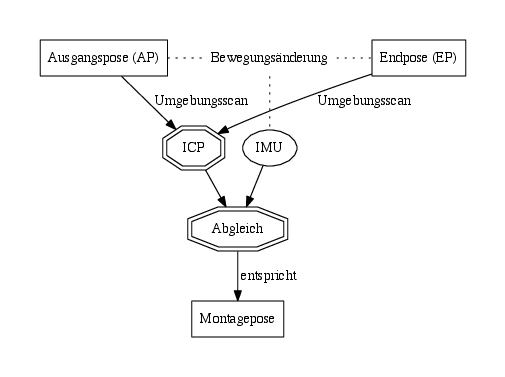

In [311]:
graph = pydot.Dot(graph_type='digraph')

graph.add_subgraph(inputs)
graph.add_node(MontagePose)
graph.add_node(ICP)
graph.add_node(IMU)
graph.add_node(Abgleich)

graph.add_edge(pydot.Edge(Ausgangspose, ICP, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Endpose, ICP, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Ausgangspose, Bewegung, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, Endpose, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, IMU, style='dotted', arrowhead='none'))

graph.add_edge(pydot.Edge(ICP, Abgleich))
graph.add_edge(pydot.Edge(IMU, Abgleich))
    
graph.add_edge(pydot.Edge(Abgleich, MontagePose, label='\ entspricht'))

graph.write_pdf('Images/kalibrierungImSC.pdf')
img = WImage(filename='Images/kalibrierungImSC.pdf')
img

#### Mit Bewegungskorrektur

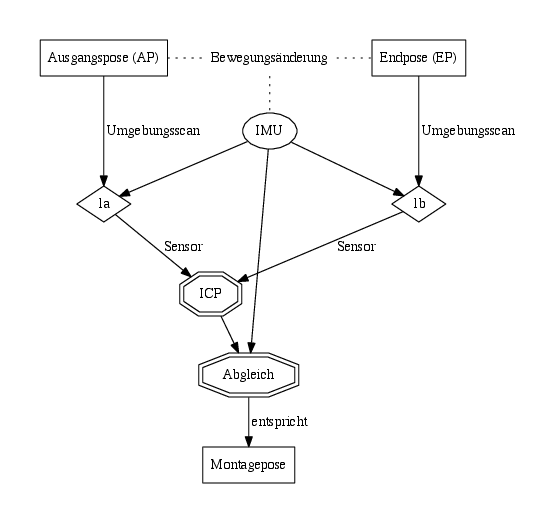

In [312]:
graph = pydot.Dot(graph_type='digraph')

Scan_zu_SK1 = pydot.Node('1a', shape='diamond', group='g1')
Scan_zu_SK2 = pydot.Node('1b', shape='diamond', group='g3')

graph.add_subgraph(inputs)
graph.add_node(Scan_zu_SK1)
graph.add_node(Scan_zu_SK2)
graph.add_node(MontagePose)
graph.add_node(ICP)
graph.add_node(IMU)
graph.add_node(Abgleich)

graph.add_edge(pydot.Edge(Ausgangspose, Scan_zu_SK1, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Endpose, Scan_zu_SK2, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Scan_zu_SK1, ICP, label='\ Sensor'))
graph.add_edge(pydot.Edge(Scan_zu_SK2, ICP, label='\ Sensor'))
graph.add_edge(pydot.Edge(Ausgangspose, Bewegung, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, Endpose, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, IMU, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(IMU, Scan_zu_SK1))
graph.add_edge(pydot.Edge(IMU, Scan_zu_SK2))

graph.add_edge(pydot.Edge(ICP, Abgleich))
graph.add_edge(pydot.Edge(IMU, Abgleich))
    
graph.add_edge(pydot.Edge(Abgleich, MontagePose, label='\ entspricht'))

graph.write_pdf('Images/kalibrierungImSCmitKorr.pdf')
img = WImage(filename='Images/kalibrierungImSCmitKorr.pdf')
img

### Im Weltkoordinatensystem

#### Ohne Bewegungskorrektur

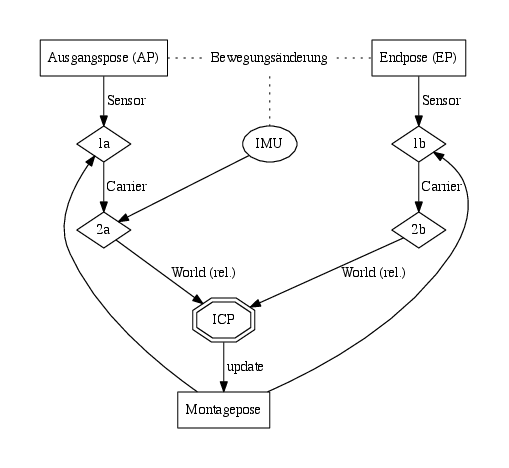

In [313]:
graph = pydot.Dot(graph_type='digraph')

SK_zu_TK1 = pydot.Node('1a', shape='diamond', group='g1')
SK_zu_TK2 = pydot.Node('1b', shape='diamond', group='g3')
TK_zu_WK1 = pydot.Node('2a', shape='diamond', group='g1')
TK_zu_WK2 = pydot.Node('2b', shape='diamond', group='g3')

scs = pydot.Subgraph(rank='same')
scs.add_node(SK_zu_TK1)
scs.add_node(SK_zu_TK2)

graph.add_subgraph(inputs)
graph.add_subgraph(scs)
graph.add_node(TK_zu_WK1)
graph.add_node(TK_zu_WK2)
graph.add_node(MontagePose)
graph.add_node(ICP)
graph.add_node(IMU)

graph.add_edge(pydot.Edge(Ausgangspose, Scan_zu_SK1, label='\ Sensor'))
graph.add_edge(pydot.Edge(Endpose, Scan_zu_SK2, label='\ Sensor'))
graph.add_edge(pydot.Edge(Scan_zu_SK1, TK_zu_WK1, label='\ Carrier'))
graph.add_edge(pydot.Edge(Scan_zu_SK2, TK_zu_WK2, label='\ Carrier'))
graph.add_edge(pydot.Edge(TK_zu_WK1, ICP, label='\ World\ (rel.)'))
graph.add_edge(pydot.Edge(TK_zu_WK2, ICP, label='\ World\ (rel.)'))
graph.add_edge(pydot.Edge(Ausgangspose, Bewegung, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, Endpose, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, IMU, style='dotted', arrowhead='none'))

graph.add_edge(pydot.Edge(IMU, TK_zu_WK1))
graph.add_edge(pydot.Edge(ICP, MontagePose, label='\ update'))
graph.add_edge(pydot.Edge(MontagePose, Scan_zu_SK1))
graph.add_edge(pydot.Edge(MontagePose, Scan_zu_SK2))

graph.write_pdf('Images/kalibrierungImWC.pdf')
img = WImage(filename='Images/kalibrierungImWC.pdf')
img

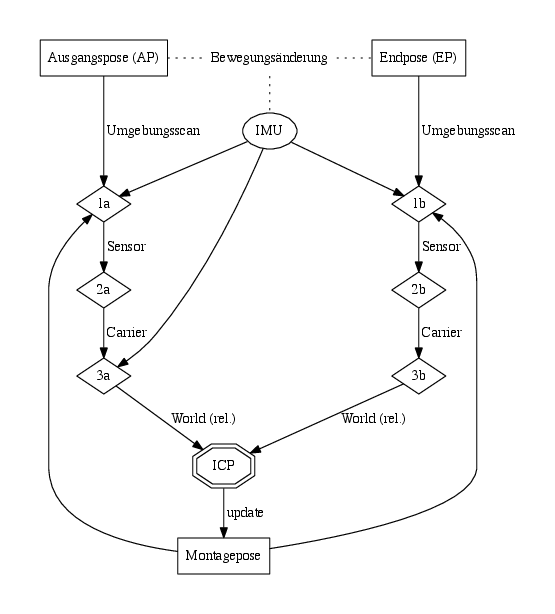

In [314]:
graph = pydot.Dot(graph_type='digraph')

SK_zu_TK1 = pydot.Node('2a', shape='diamond', group='g1')
SK_zu_TK2 = pydot.Node('2b', shape='diamond', group='g3')
TK_zu_WK1 = pydot.Node('3a', shape='diamond', group='g1')
TK_zu_WK2 = pydot.Node('3b', shape='diamond', group='g3')

graph.add_subgraph(inputs)
graph.add_node(Scan_zu_SK1)
graph.add_node(Scan_zu_SK2)
graph.add_node(SK_zu_TK1)
graph.add_node(SK_zu_TK2)
graph.add_subgraph(scs)
graph.add_node(TK_zu_WK1)
graph.add_node(TK_zu_WK2)
graph.add_node(MontagePose)
graph.add_node(ICP)
graph.add_node(IMU)

graph.add_edge(pydot.Edge(Ausgangspose, Scan_zu_SK1, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Endpose, Scan_zu_SK2, label='\ Umgebungsscan'))
graph.add_edge(pydot.Edge(Scan_zu_SK1, SK_zu_TK1 , label='\ Sensor'))
graph.add_edge(pydot.Edge(Scan_zu_SK2, SK_zu_TK2, label='\ Sensor'))
graph.add_edge(pydot.Edge(SK_zu_TK1, TK_zu_WK1, label='\ Carrier'))
graph.add_edge(pydot.Edge(SK_zu_TK2, TK_zu_WK2, label='\ Carrier'))
graph.add_edge(pydot.Edge(TK_zu_WK1, ICP, label='\ World\ (rel.)'))
graph.add_edge(pydot.Edge(TK_zu_WK2, ICP, label='\ World\ (rel.)'))
graph.add_edge(pydot.Edge(Ausgangspose, Bewegung, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, Endpose, style='dotted', arrowhead='none'))
graph.add_edge(pydot.Edge(Bewegung, IMU, style='dotted', arrowhead='none'))

graph.add_edge(pydot.Edge(IMU, Scan_zu_SK1))
graph.add_edge(pydot.Edge(IMU, Scan_zu_SK2))
graph.add_edge(pydot.Edge(IMU, TK_zu_WK1))
graph.add_edge(pydot.Edge(ICP, MontagePose, label='\ update'))
graph.add_edge(pydot.Edge(MontagePose, Scan_zu_SK1))
graph.add_edge(pydot.Edge(MontagePose, Scan_zu_SK2))

graph.write_pdf('Images/kalibrierungImWCmitKorr.pdf')
img = WImage(filename='Images/kalibrierungImWCmitKorr.pdf')
img

#### Mit Bewegungskorrektur

Laserscanner Velodyne HDL-32e

In [316]:
%%asy --root Images/velodyne
settings.render=16;
shipout(scale(4.0)*currentpicture.fit());
import three;
import graph3;
import solids;
currentprojection=orthographic(3,4,1, center=true);

size(15cm);
pen outside = white+opacity(1);

real height=0.8;
path3 laserBase = path3((-0.4,0.7) -- (-0.5,sin(acos(-0.5))) .. (-1,0) .. (0,-1) .. (1,0) .. (0.5,sin(acos(0.5))) -- (0.4,0.7));
surface laserEye = extrude(laserBase --- cycle, height*Z);

draw(shift(0.9Z) * scale(1,1,0.4) * unithemisphere, surfacepen=outside); // Top
draw(shift(0.4Z) * scale(1,1,0.5) * unitcylinder, surfacepen=outside);   // upper rotating Head
draw(shift(-height/2*Z) * laserEye, surfacepen=white+opacity(0.8));      // Laser-Eye
draw(shift(-0.7Z) * scale(1,1,0.3) * unitcylinder, surfacepen=outside);  // lower rotating Head
draw(shift(-1.7Z) * scale(1,1,0.95) * unitcylinder, surfacepen=outside); // Base

draw(rotate(-90,X) * (O--3Y), red, Arrow3(emissive(red)), L=Label("$Y$", position=EndPoint));
draw(rotate(-90,X) * (O--3Z), red, Arrow3(emissive(red)), L=Label("$Z$", position=EndPoint));
draw(rotate(-90,X) * arc(c=(0,0,0),1.1Z, 1.1X), red, arrow=Arrow3(emissive(red)), L=Label("$\Theta$"));